In [1]:
# ============================================================================
# Import Libraries
# ============================================================================
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns

In [2]:
# ============================================================================
# Helper Functions
# ============================================================================

# Print formatted step header with step number, title and optional explanation
def print_step_header(step_number, step_title, explanation=None):
    print(f"\n{'='*75}")
    print(f"# STEP {step_number}: {step_title}")
    print(f"{'='*75}")
    if explanation:
        print(f"# Explanation: {explanation}")

# Print formatted section title with separator lines
def print_section_title(title, subtitle=None):
    """
    Print a formatted section title with separator lines.

    Parameters:
    - title: Main title text (will be prefixed with '#')
    - subtitle: Optional subtitle text (will be prefixed with '#')
    """
    print(f"\n{'='*75}")
    print(f"# {title}")
    print(f"{'='*75}")
    if subtitle:
        print(f"# {subtitle}")

# Analyze field type conversion: original type, target type, and conversion reason
def type_conversion(df, field_name, target_type, conversion_reason, field_description=None):
    if field_name not in df.columns:
        print(f"   - Field '{field_name}' not found in dataset")
        return df

    # Get original type directly from DataFrame (before conversion)
    original_type = str(df[field_name].dtype)
    if field_description:
        print(f"   - Field description: {field_description}")
    print(f"   - Original type: {original_type}")
    print(f"   - Target type: {target_type}")
    print(f"   - Conversion reason: {conversion_reason}")

    # Check if conversion is needed
    if original_type == target_type or original_type == target_type.replace('64', '32'):
        print(f"   - Status: No conversion needed (already {target_type})")
        return df

    try:
        # Perform actual type conversion
        if target_type == 'datetime64[ns]':
            df[field_name] = pd.to_datetime(df[field_name], errors='coerce')
        elif target_type == 'category':
            # Convert to object type instead of category for better compatibility with statistical calculations
            df[field_name] = df[field_name].astype('object')
        elif target_type == 'bool':
            # Convert yes/no, Y/N, True/False to boolean
            if df[field_name].dtype == 'object':
                # Map common boolean representations
                bool_map = {
                    'Yes': True, 'Y': True, 'yes': True, 'y': True, 'True': True, 'true': True, 'TRUE': True,
                    'No': False, 'N': False, 'no': False, 'n': False, 'False': False, 'false': False, 'FALSE': False
                }
                df[field_name] = df[field_name].map(bool_map)
                # Fill any unmapped values with False (or handle NaN appropriately)
                # Use where method to avoid FutureWarning about downcasting
                df[field_name] = df[field_name].where(df[field_name].notna(), False)
            df[field_name] = df[field_name].astype('bool')
        elif target_type == 'float64':
            df[field_name] = pd.to_numeric(df[field_name], errors='coerce').astype('float64')
        elif target_type == 'int64':
            # Convert to numeric first (handles NaN)
            numeric_series = pd.to_numeric(df[field_name], errors='coerce')
            # Check if there are any NaN values
            if numeric_series.isna().any():
                # Use nullable integer type (Int64) to preserve NaN
                df[field_name] = numeric_series.astype('Int64')
                print(f"   - Note: Field contains missing values, using nullable integer type (Int64)")
            else:
                # No NaN values, can safely convert to int64
                df[field_name] = numeric_series.astype('int64')
        elif target_type == 'object':
            df[field_name] = df[field_name].astype('object')
        else:
            # Generic conversion
            df[field_name] = df[field_name].astype(target_type)

        new_type = str(df[field_name].dtype)
        print(f"   - Status: Converted successfully to {new_type}")

    except Exception as e:
        print(f"   - Status: Conversion failed - {str(e)}")

    return df

# Print statistical summary for a categorical column including unique values, missing values and top frequencies
def print_categorical_summary(df, col):

    unique_count = df[col].nunique()
    null_count = df[col].isnull().sum()
    null_pct = (null_count / len(df)) * 100

    print(f"\n{col}:")
    print(f"  - Unique values: {unique_count:,}")
    print(f"  - Missing values: {null_count:,} ({null_pct:.2f}%)")

    # Show top values based on cardinality
    if unique_count <= 20:
        top_n = 10
        label = "Top values"
    elif unique_count <= 100:
        top_n = 5
        label = "Top 5 values"
    else:
        top_n = 1
        label = "Most frequent"

    value_counts = df[col].value_counts().head(top_n)
    print(f"  - {label}:")
    for val, count in value_counts.items():
        pct = (count / len(df)) * 100
        print(f"    * {val}: {count:,} ({pct:.1f}%)")

    if unique_count > 100:
        print(f"  - Note: High cardinality ({unique_count:,} unique values) - consider grouping for analysis")

# Plot distribution charts (histograms, bar charts) for numeric, boolean or categorical variables
def plot_distributions(df, columns, var_type='numeric'):

    if len(columns) == 0:
        return

    n_cols = min(3, len(columns))
    n_rows = (len(columns) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))

    # Handle different subplot configurations
    if n_rows == 1 and n_cols == 1:
        # Single subplot: axes is a single Axes object
        axes = [axes]
    elif n_rows == 1:
        # Single row: axes is a 1D array
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    else:
        # Multiple rows: axes is a 2D array
        axes = axes.flatten()

    for idx, col in enumerate(columns):
        ax = axes[idx]

        if var_type == 'numeric':
            # Histogram for numeric variables
            df[col].hist(bins=50, ax=ax, edgecolor='black')
            ax.set_title(f'Distribution of {col}')
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')
            ax.grid(True, alpha=0.3)

        elif var_type == 'boolean':
            # Bar chart for boolean variables
            value_counts = df[col].value_counts()

            # Use different colors for True/False
            colors = ['#1f77b4' if val else '#ff7f0e' for val in value_counts.index]
            value_counts.plot(kind='bar', ax=ax, edgecolor='black', color=colors)
            ax.set_title(f'Distribution of {col}')
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')
            ax.tick_params(axis='x', rotation=0)
            ax.grid(True, alpha=0.3, axis='y')

            # Add percentage labels on bars
            total = len(df[col].dropna())
            for i, (val, count) in enumerate(value_counts.items()):
                pct = (count / total) * 100 if total > 0 else 0
                ax.text(i, count, f'{count:,}\n({pct:.1f}%)',
                       ha='center', va='bottom', fontsize=9)

        elif var_type == 'categorical':
            # Bar chart for categorical variables
            unique_count = df[col].nunique()

            if unique_count <= 20:
                # Show all values
                value_counts = df[col].value_counts()
            else:
                # Show top 10
                value_counts = df[col].value_counts().head(10)

            value_counts.plot(kind='bar', ax=ax, edgecolor='black')
            ax.set_title(f'Distribution of {col}')
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, alpha=0.3, axis='y')

    # Hide unused subplots
    for idx in range(len(columns), len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

In [3]:
# ============================================================================
# SECTION 3: DATA UNDERSTANDING
# ============================================================================
print_step_header("3", "Data Understanding")

# ============================================================================
# STEP 3.1: Collect initial data
# ============================================================================
print_step_header("3.1", "Collect initial data")

# ============================================================================
# 3.1.1. Data Source
# ============================================================================
# Dataset: Traffic Violations dataset from Montgomery County
# Data Source URL: https://data.montgomerycountymd.gov/Public-Safety/Traffic-Violations/4mse-ku6q/about_data
# Format: CSV file
# File location: TrafficViolations.csv



# STEP 3: Data Understanding

# STEP 3.1: Collect initial data


In [7]:
# ============================================================================
# 3.1.2. Data Loading
# ============================================================================

random.seed(2025)
np.random.seed(2025)

# Read the data
df = pd.read_csv('TrafficViolations.csv')

print(df.head())

                                  SeqID Date Of Stop Time Of Stop Agency  \
0  1a94c7c8-8f5d-4eaf-acee-6fe3d085b3e8   10/29/2025     17:43:00    MCP   
1  7c0a64ca-ca15-4941-8279-9a65901adba7   10/29/2025     17:38:00    MCP   
2  508225e8-e463-4aef-9886-dadd741132a5   10/29/2025     17:33:00    MCP   
3  b659d674-dbf9-403d-9d24-94af28b7ea63   10/29/2025     17:10:00    MCP   
4  b659d674-dbf9-403d-9d24-94af28b7ea63   10/29/2025     17:10:00    MCP   

                                         SubAgency  \
0                           2nd District, Bethesda   
1  6th District, Gaithersburg / Montgomery Village   
2                           2nd District, Bethesda   
3                           2nd District, Bethesda   
4                           2nd District, Bethesda   

                                         Description  \
0  DISPLAYING EXPIRED REGISTRATION PLATE ISSUED B...   
1  OPERATING VEHICLE ON HIGHWAY WITH UNAUTHORIZED...   
2  DRIVER USING HANDS TO USE HANDHELD TELEPHONE W.

In [8]:
# ============================================================================
# STEP 3.2: Describe data
# ============================================================================
print_step_header("3.2", "Describe data")

# ============================================================================
# 3.2.1. Field Type Analysis (Hardcoded)
# ============================================================================
print_step_header("3.2.0", "Field Type Analysis (Hardcoded)")

print("\nData types for all 43 fields:")

# Field 1: SeqID
print("\n1. SeqID:")
df = type_conversion(
    df, 'SeqID', 'object',
    "UUID identifier; excluded from models",
    "Unique sequence identifier for the traffic stop record"
)

# Field 2: Date Of Stop
print("\n2. Date Of Stop:")
df = type_conversion(
    df, 'Date Of Stop', 'datetime64[ns]',
    "For time-based analysis, trend analysis, seasonal pattern identification, and temporal feature engineering",
    "Date when the traffic stop occurred"
)

# Field 3: Time Of Stop
print("\n3. Time Of Stop:")
df = type_conversion(
    df, 'Time Of Stop', 'object',
    "For temporal pattern analysis, hour feature extraction, and time-of-day violation pattern identification",
    "Time when the traffic stop occurred"
)

# Field 4: Agency
print("\n4. Agency:")
df = type_conversion(
    df, 'Agency', 'object',
    "For inter-agency comparison, grouping analysis, and law enforcement efficiency assessment",
    "Law enforcement agency that conducted the stop"
)

# Field 5: SubAgency
print("\n5. SubAgency:")
df = type_conversion(
    df, 'SubAgency', 'object',
    "For sub-agency comparison, regional grouping analysis, and enforcement pattern identification",
    "Sub-agency or division that conducted the stop"
)

# Field 6: Description
print("\n6. Description:")
df = type_conversion(
    df, 'Description', 'object',
    "For violation description text analysis, keyword extraction, and violation pattern identification from text",
    "Description of the traffic violation incident"
)

# Field 7: Location
print("\n7. Location:")
df = type_conversion(
    df, 'Location', 'object',
    "For location text analysis, geocoding, address parsing, and geographic feature engineering",
    "Location where the traffic stop occurred"
)

# Field 8: Latitude
print("\n8. Latitude:")
df = type_conversion(
    df, 'Latitude', 'float64',
    "For precise geographic calculations, spatial analysis, hotspot identification, and geographic feature engineering",
    "Latitude coordinate of the stop location"
)

# Field 9: Longitude
print("\n9. Longitude:")
df = type_conversion(
    df, 'Longitude', 'float64',
    "For precise geographic calculations, spatial analysis, hotspot identification, and geographic feature engineering",
    "Longitude coordinate of the stop location"
)

# Field 10: Accident
print("\n10. Accident:")
df = type_conversion(
    df, 'Accident', 'bool',
    "For accident correlation analysis, risk factor identification, and conditional filtering",
    "Whether an accident was involved"
)

# Field 11: Belts
print("\n11. Belts:")
df = type_conversion(
    df, 'Belts', 'bool',
    "For safety measure analysis, accident severity correlation analysis, and feature engineering",
    "Whether seat belts were used"
)

# Field 12: Personal Injury
print("\n12. Personal Injury:")
df = type_conversion(
    df, 'Personal Injury', 'bool',
    "For accident severity analysis, risk assessment, and outcome prediction",
    "Whether there was personal injury"
)

# Field 13: Property Damage
print("\n13. Property Damage:")
df = type_conversion(
    df, 'Property Damage', 'bool',
    "For accident consequence analysis, loss assessment, and risk factor identification",
    "Whether there was property damage"
)

# Field 14: Fatal
print("\n14. Fatal:")
df = type_conversion(
    df, 'Fatal', 'bool',
    "For severe accident analysis, fatal factor identification, and risk assessment",
    "Whether the incident was fatal"
)

# Field 15: Commercial License
print("\n15. Commercial License:")
df = type_conversion(
    df, 'Commercial License', 'bool',
    "For driver type analysis, violation pattern identification, and feature engineering",
    "Whether the driver had a commercial license"
)

# Field 16: HAZMAT
print("\n16. HAZMAT:")
df = type_conversion(
    df, 'HAZMAT', 'bool',
    "For hazardous material transport analysis, risk assessment, and special vehicle identification",
    "Whether hazardous materials were involved"
)

# Field 17: Commercial Vehicle
print("\n17. Commercial Vehicle:")
df = type_conversion(
    df, 'Commercial Vehicle', 'bool',
    "For vehicle type analysis, commercial vehicle violation pattern identification, and feature engineering",
    "Whether the vehicle was commercial"
)

# Field 18: Alcohol
print("\n18. Alcohol:")
df = type_conversion(
    df, 'Alcohol', 'bool',
    "For DUI analysis, serious violation identification, and risk factor analysis",
    "Whether alcohol was involved"
)

# Field 19: Work Zone
print("\n19. Work Zone:")
df = type_conversion(
    df, 'Work Zone', 'bool',
    "For construction zone analysis, special area violation pattern identification, and risk assessment",
    "Whether the incident occurred in a work zone"
)

# Field 20: Search Conducted
print("\n20. Search Conducted:")
df = type_conversion(
    df, 'Search Conducted', 'bool',
    "For search behavior analysis, enforcement pattern identification, and conditional filtering",
    "Whether a search was conducted"
)

# Field 21: Search Disposition
print("\n21. Search Disposition:")
df = type_conversion(
    df, 'Search Disposition', 'object',
    "For search disposition type analysis, enforcement procedure assessment, and grouped statistics",
    "Disposition of the search conducted"
)

# Field 22: Search Outcome
print("\n22. Search Outcome:")
df = type_conversion(
    df, 'Search Outcome', 'object',
    "For search outcome analysis, search effectiveness evaluation, and pattern identification",
    "Outcome of the search conducted"
)

# Field 23: Search Reason
print("\n23. Search Reason:")
df = type_conversion(
    df, 'Search Reason', 'object',
    "For search reason analysis, enforcement reasonableness assessment, and reason categorization",
    "Reason for conducting the search"
)

# Field 24: Search Reason For Stop
print("\n24. Search Reason For Stop:")
df = type_conversion(
    df, 'Search Reason For Stop', 'object',
    "For stop reason analysis, search trigger factor identification, and correlation analysis",
    "Reason for the stop that led to search"
)

# Field 25: Search Type
print("\n25. Search Type:")
df = type_conversion(
    df, 'Search Type', 'object',
    "For search type analysis, enforcement method categorization, and pattern identification",
    "Type of search conducted"
)

# Field 26: Search Arrest Reason
print("\n26. Search Arrest Reason:")
df = type_conversion(
    df, 'Search Arrest Reason', 'object',
    "For arrest reason analysis, search-to-arrest correlation analysis, and outcome prediction",
    "Reason for arrest if search led to arrest"
)

# Field 27: State
print("\n27. State:")
df = type_conversion(
    df, 'State', 'object',
    "For geographic grouping analysis, inter-regional comparison, and geographic feature engineering",
    "US state where the stop occurred"
)

# Field 28: VehicleType
print("\n28. VehicleType:")
df = type_conversion(
    df, 'VehicleType', 'object',
    "For vehicle type analysis, violation pattern identification, and feature engineering",
    "Type of vehicle involved"
)

# Field 29: Year
print("\n29. Year:")
df = type_conversion(
    df, 'Year', 'int64',
    "For vehicle age analysis, numeric calculations, filtering, and feature engineering. Missing values (NaN) will be filled later when needed",
    "Year of the vehicle"
)

# Field 30: Make
print("\n30. Make:")
df = type_conversion(
    df, 'Make', 'object',
    "For vehicle brand analysis, inter-brand violation pattern comparison, and feature engineering",
    "Make/manufacturer of the vehicle"
)

# Field 31: Model
print("\n31. Model:")
df = type_conversion(
    df, 'Model', 'object',
    "For vehicle model analysis, specific model violation pattern identification, and feature engineering",
    "Model of the vehicle"
)

# Field 32: Color
print("\n32. Color:")
df = type_conversion(
    df, 'Color', 'object',
    "For vehicle color analysis, color-violation correlation analysis, and feature engineering",
    "Color of the vehicle"
)

# Field 33: Violation Type
print("\n33. Violation Type:")
df = type_conversion(
    df, 'Violation Type', 'object',
    "For violation type classification analysis, violation pattern identification, and target variable construction",
    "Type of traffic violation"
)

# Field 34: Charge
print("\n34. Charge:")
df = type_conversion(
    df, 'Charge', 'object',
    "For legal charge analysis, charge pattern identification, and legal text pattern matching",
    "Charge filed against the driver"
)

# Field 35: Article
print("\n35. Article:")
df = type_conversion(
    df, 'Article', 'object',
    "For legal article analysis, statute pattern identification, and legal text pattern matching",
    "Legal article or statute related to the violation"
)

# Field 36: Contributed To Accident
print("\n36. Contributed To Accident:")
df = type_conversion(
    df, 'Contributed To Accident', 'bool',
    "For violation-accident correlation analysis, causal relationship identification, and risk assessment",
    "Whether the violation contributed to an accident"
)

# Field 37: Race
print("\n37. Race:")
df = type_conversion(
    df, 'Race', 'object',
    "For demographic analysis, fairness assessment, and grouped comparison analysis",
    "Race/ethnicity of the driver"
)

# Field 38: Gender
print("\n38. Gender:")
df = type_conversion(
    df, 'Gender', 'object',
    "For gender analysis, gender-based violation pattern difference analysis, and grouped statistics",
    "Gender of the driver"
)

# Field 39: Driver City
print("\n39. Driver City:")
df = type_conversion(
    df, 'Driver City', 'object',
    "For driver residence location analysis, geographic pattern identification, and feature engineering",
    "City where the driver resides"
)

# Field 40: Driver State
print("\n40. Driver State:")
df = type_conversion(
    df, 'Driver State', 'object',
    "For driver residence state analysis, cross-state violation pattern identification, and geographic feature engineering",
    "US state where the driver resides"
)

# Field 41: DL State
print("\n41. DL State:")
df = type_conversion(
    df, 'DL State', 'object',
    "For license issuing state analysis, cross-state driving pattern identification, and feature engineering",
    "State that issued the driver's license"
)

# Field 42: Arrest Type
print("\n42. Arrest Type:")
df = type_conversion(
    df, 'Arrest Type', 'object',
    "For arrest type analysis, arrest pattern categorization, and outcome prediction",
    "Type of arrest made during the stop"
)

# Field 43: Geolocation
print("\n43. Geolocation:")
df = type_conversion(
    df, 'Geolocation', 'object',
    "For spatial analysis, geographic pattern identification, and coordinate parsing. Field may contain coordinate strings or geographic objects",
    "Geographic location information of the stop"
)

print("\n" + "="*75)
print("Field type analysis completed (43 fields analyzed)")
print("="*75)


# STEP 3.2: Describe data

# STEP 3.2.0: Field Type Analysis (Hardcoded)

Data types for all 43 fields:

1. SeqID:
   - Field description: Unique sequence identifier for the traffic stop record
   - Original type: object
   - Target type: object
   - Conversion reason: UUID identifier; excluded from models
   - Status: No conversion needed (already object)

2. Date Of Stop:
   - Field description: Date when the traffic stop occurred
   - Original type: object
   - Target type: datetime64[ns]
   - Conversion reason: For time-based analysis, trend analysis, seasonal pattern identification, and temporal feature engineering
   - Status: Converted successfully to datetime64[ns]

3. Time Of Stop:
   - Field description: Time when the traffic stop occurred
   - Original type: object
   - Target type: object
   - Conversion reason: For temporal pattern analysis, hour feature extraction, and time-of-day violation pattern identification
   - Status: No conversion needed (already object)

4. Age

In [9]:
# ============================================================================
# 3.2.2. Data Preview
# ============================================================================
print_step_header("3.2.4", "Data Preview")
df.info()


# STEP 3.2.4: Data Preview
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057154 entries, 0 to 2057153
Data columns (total 43 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   SeqID                    object        
 1   Date Of Stop             datetime64[ns]
 2   Time Of Stop             object        
 3   Agency                   object        
 4   SubAgency                object        
 5   Description              object        
 6   Location                 object        
 7   Latitude                 float64       
 8   Longitude                float64       
 9   Accident                 bool          
 10  Belts                    bool          
 11  Personal Injury          bool          
 12  Property Damage          bool          
 13  Fatal                    bool          
 14  Commercial License       bool          
 15  HAZMAT                   bool          
 16  Commercial Vehicle       bool          
 17 

In [10]:
# ============================================================================
# 3.2.3. Basic Statistics
# ============================================================================
print_step_header("3.2.3", "Basic Statistics")
numeric_cols_preview = df.select_dtypes(include=[np.number]).columns.tolist()
if numeric_cols_preview:
    print_section_title("Numeric columns", "Descriptive statistics for numeric columns:")
    print(df[numeric_cols_preview].describe())

categorical_cols_preview = df.select_dtypes(include=['object']).columns.tolist()
if categorical_cols_preview:
    print_section_title("Categorical columns", "Unique values count for categorical columns:")
    # Calculate unique counts and sort by count (descending)
    col_unique_counts = [(col, df[col].nunique()) for col in categorical_cols_preview]
    col_unique_counts.sort(key=lambda x: x[1], reverse=True)
    for col, unique_count in col_unique_counts:
        print(f"    - {col}: {unique_count} unique values")

boolean_cols_preview = df.select_dtypes(include=['bool']).columns.tolist()
if boolean_cols_preview:
    print_section_title("Boolean columns", "Value counts for boolean columns:")
    for col in boolean_cols_preview:
        value_counts = df[col].value_counts()
        print(f"    - {col}:")
        for val, count in value_counts.items():
            pct = (count / len(df)) * 100
            print(f"      - {val}: {count:,} ({pct:.2f}%)")


# STEP 3.2.3: Basic Statistics

# Numeric columns
# Descriptive statistics for numeric columns:
           Latitude     Longitude         Year
count  2.057154e+06  2.057154e+06    2046519.0
mean   3.615806e+01 -7.134118e+01  2007.565071
std    1.028822e+01  2.029915e+01    85.124201
min    0.000000e+00 -1.512560e+02          0.0
25%    3.901650e+01 -7.719288e+01       2003.0
50%    3.906616e+01 -7.708751e+01       2008.0
75%    3.913688e+01 -7.702697e+01       2013.0
max    4.154316e+01  3.906444e+01       9999.0

# Categorical columns
# Unique values count for categorical columns:
    - SeqID: 1170138 unique values
    - Geolocation: 1019534 unique values
    - Location: 267955 unique values
    - Model: 23322 unique values
    - Description: 17709 unique values
    - Driver City: 9346 unique values
    - Make: 4918 unique values
    - Time Of Stop: 1440 unique values
    - Charge: 1198 unique values
    - Search Reason For Stop: 835 unique values
    - State: 72 unique values
    - 

In [12]:
# ============================================================================
# STEP 3.3: Explore data
# ============================================================================
print_step_header("3.3", "Explore data")

# Identify different types of columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
bool_cols = df.select_dtypes(include=[bool]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Exclude ID and geolocation tuple columns from analysis
exclude_cols = ['SeqID']  # Add other ID columns if needed
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
categorical_cols = [col for col in categorical_cols if col not in exclude_cols]


# STEP 3.3: Explore data



# STEP 3.3.1: Numeric Variable Distributions
# Explanation: Visualize distributions of numeric variables


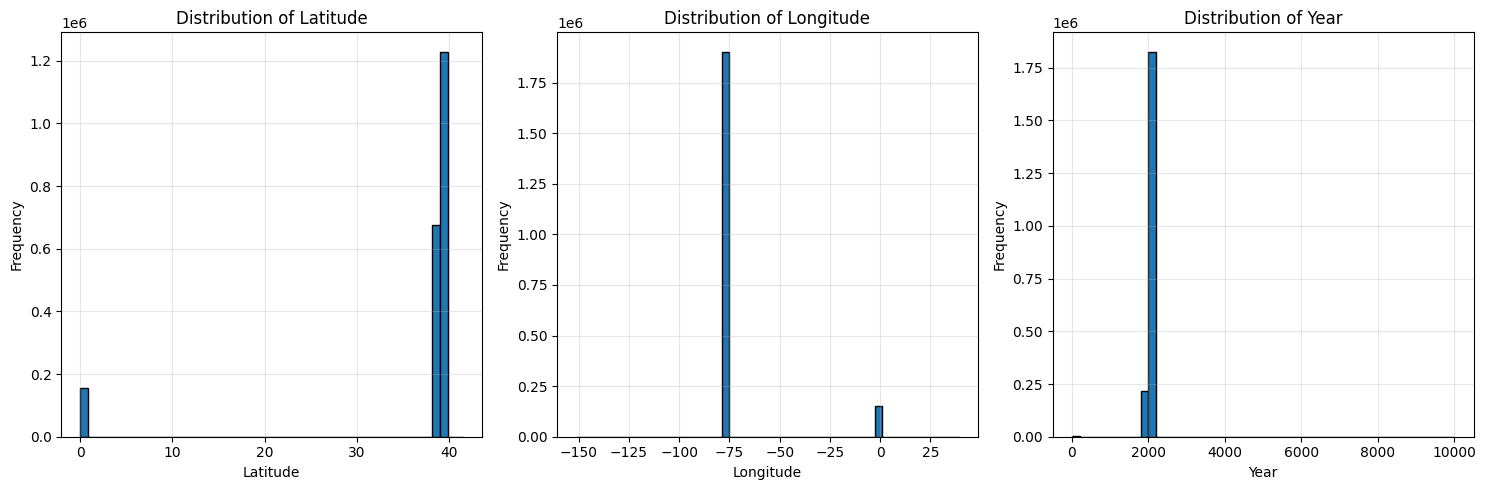

In [13]:
# ============================================================================
# 3.3.1: Numeric Variable Distributions
# ============================================================================
print_step_header("3.3.1", "Numeric Variable Distributions",
                  "Visualize distributions of numeric variables")
if numeric_cols:
    plot_distributions(df, numeric_cols, var_type='numeric')


# STEP 3.3.2: Boolean Variable Distributions
# Explanation: Visualize distributions of boolean variables


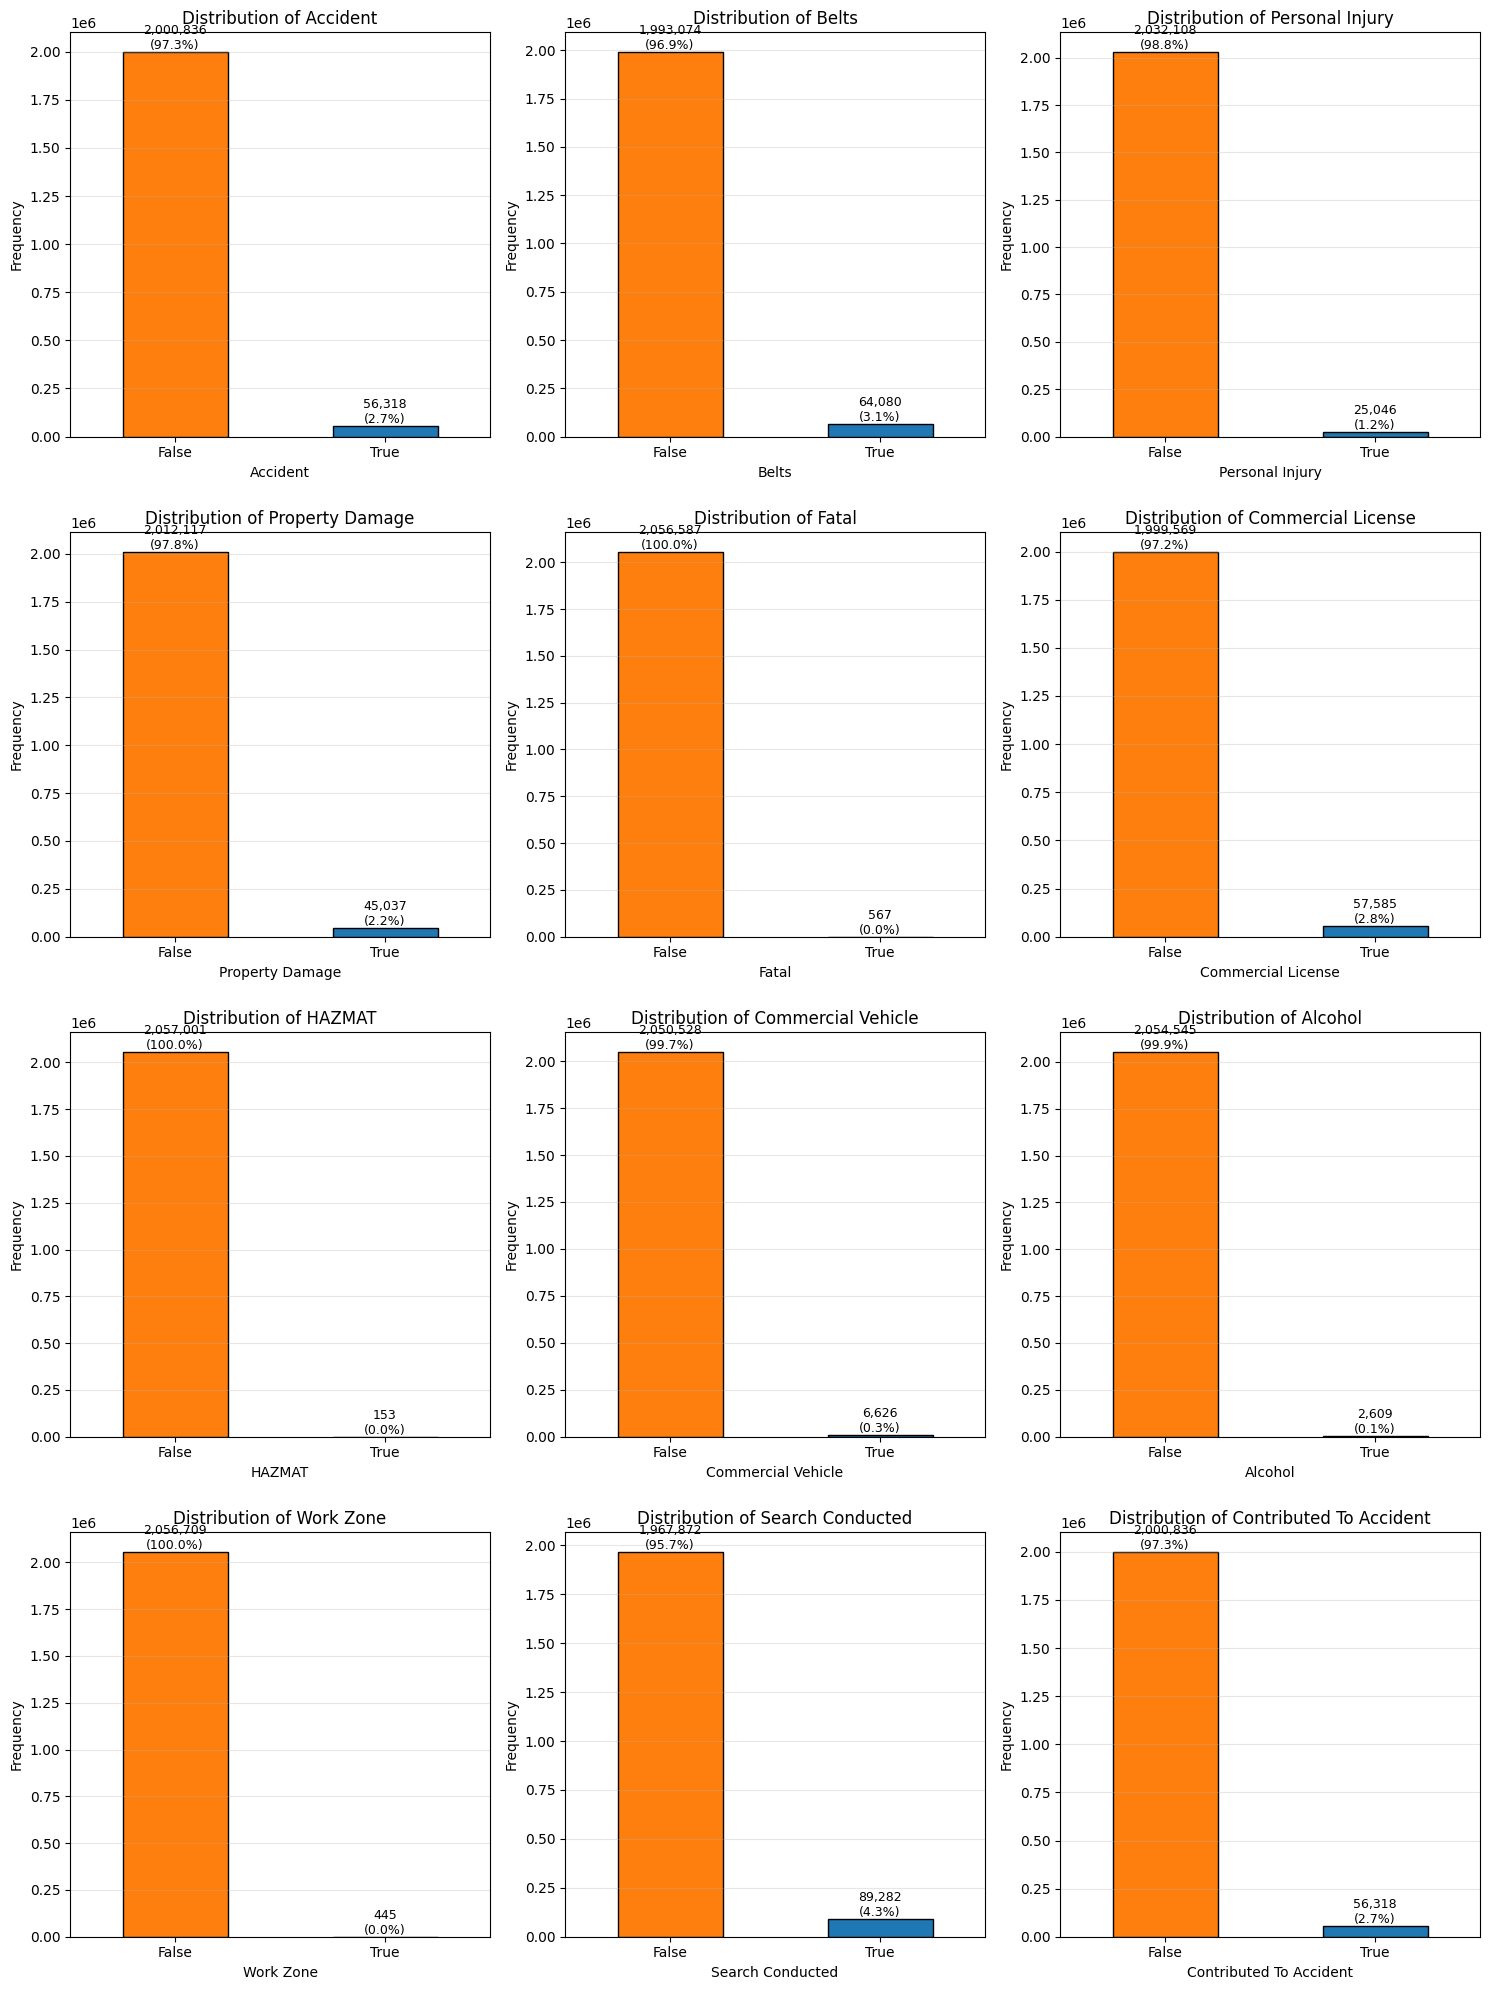

In [14]:
# ============================================================================
# 3.3.2: Boolean Variable Distributions
# ============================================================================
print_step_header("3.3.2", "Boolean Variable Distributions",
                  "Visualize distributions of boolean variables")
if bool_cols:
    plot_distributions(df, bool_cols, var_type='boolean')

In [15]:
# ============================================================================
# 3.3.3: Categorical Variable Distributions
# ============================================================================
print_step_header("3.3.3", "Categorical Variable Distributions")
# Print summary statistics for all categorical variables (no visualization)
if categorical_cols:
    print("\nAll categorical variables explored:")
    for col in categorical_cols:
        print_categorical_summary(df, col)


# STEP 3.3.3: Categorical Variable Distributions

All categorical variables explored:

Time Of Stop:
  - Unique values: 1,440
  - Missing values: 0 (0.00%)
  - Most frequent:
    * 23:30:00: 2,996 (0.1%)
  - Note: High cardinality (1,440 unique values) - consider grouping for analysis

Agency:
  - Unique values: 1
  - Missing values: 0 (0.00%)
  - Top values:
    * MCP: 2,057,154 (100.0%)

SubAgency:
  - Unique values: 9
  - Missing values: 0 (0.00%)
  - Top values:
    * 4th District, Wheaton: 447,592 (21.8%)
    * 3rd District, Silver Spring: 371,970 (18.1%)
    * 2nd District, Bethesda: 323,141 (15.7%)
    * 6th District, Gaithersburg / Montgomery Village: 260,116 (12.6%)
    * 5th District, Germantown: 243,963 (11.9%)
    * 1st District, Rockville: 239,572 (11.6%)
    * Headquarters and Special Operations: 170,790 (8.3%)
    * W15: 7 (0.0%)
    * S15: 3 (0.0%)

Description:
  - Unique values: 17,709
  - Missing values: 10 (0.00%)
  - Most frequent:
    * DRIVER FAILURE TO OBEY PRO

In [16]:
# ============================================================================
# 3.4. Verify data quality
# ============================================================================
print_step_header("3.4", "Verify data quality")

# ============================================================================
# 3.4.1. Duplicate data
# ============================================================================
print_step_header("3.4.1", "Duplicate data")
# Group by SeqID and check for duplicate counts
seqid_counts = df['SeqID'].value_counts()
duplicate_seqids = seqid_counts[seqid_counts > 1].sort_values(ascending=False)

if not duplicate_seqids.empty:
    print(f"  - SeqID values with duplicates: {len(duplicate_seqids)}")
    print("  - Top 5 duplicate SeqID counts (descending):")
    print(duplicate_seqids.head(5).to_string())
else:
    print("  - No duplicate SeqID values found")


# STEP 3.4: Verify data quality

# STEP 3.4.1: Duplicate data
  - SeqID values with duplicates: 422548
  - Top 5 duplicate SeqID counts (descending):
SeqID
33c49de3-9e36-4f36-9326-b59a95e86fe8    59
75f55258-401e-4a3d-87e6-ff9394acb877    43
6c64b741-3b7e-4658-9fed-fd5c3af27250    43
28c5bfc1-5670-4751-be16-e1d83cda20f0    42
c474e98e-128c-40e0-a487-d988cc67f0bd    40


In [17]:
# ============================================================================
# 3.4.2. Columns with missing values
# ============================================================================
print_step_header("3.4.2", "Columns with missing values")
missing_cols = df.columns[df.isnull().any()].tolist()
# Sort columns by missing count (descending)
missing_data = [(col, df[col].isnull().sum()) for col in missing_cols]
missing_data.sort(key=lambda x: x[1], reverse=True)
for col, missing_count in missing_data:
    missing_pct_col = (missing_count / df.shape[0]) * 100
    print(f"  - {col}: {missing_count:,} ({missing_pct_col:.2f}%)")


# STEP 3.4.2: Columns with missing values
  - Search Arrest Reason: 1,995,418 (97.00%)
  - Search Type: 1,967,880 (95.66%)
  - Search Disposition: 1,967,872 (95.66%)
  - Search Reason: 1,967,872 (95.66%)
  - Search Outcome: 801,075 (38.94%)
  - Search Reason For Stop: 782,087 (38.02%)
  - Article: 92,167 (4.48%)
  - Color: 22,257 (1.08%)
  - Year: 10,635 (0.52%)
  - DL State: 929 (0.05%)
  - Driver City: 517 (0.03%)
  - Model: 223 (0.01%)
  - Make: 74 (0.00%)
  - State: 59 (0.00%)
  - Driver State: 11 (0.00%)
  - Description: 10 (0.00%)
  - Location: 4 (0.00%)


In [27]:
# ============================================================================
# 5.1 Data Preparation
# ============================================================================

# ============================================================================
# 5.1.1. Select data
# ============================================================================
# Requirement: Select relevant features that are numeric or transformed to numeric/scaled form suitable for K-means distance computations.
# Goal: To identify meaningful clusters of traffic violation patterns by grouping similar records based on the selected features.
# Outcome: A multi-dimensional dataset narrowed down to carefully chosen, domain-relevant features.

print_step_header("5.1.1", "Select Data - Select and justify features for K-means clustering and outlier detection")

# ============================================================================
# Step 1: Select and justify features for K-means clustering and outlier detection
# ============================================================================

print_step_header("Step 1", "Select and justify features for K-means clustering and outlier detection")

# Copy data to work with for outlier detection and clustering
dfoutlier = df.copy()

# Define feature groups relevant for the analysis based on domain knowledge and model requirements
feature_groups = {
    'Geographic': ['Latitude', 'Longitude'],
    'Temporal': ['Date Of Stop', 'Time Of Stop'],
    'Severity': ['Accident', 'Personal Injury', 'Property Damage', 'Fatal'],  # KEY
    'Risk': ['Alcohol', 'Work Zone'],
    'Vehicle': ['Year', 'VehicleType', 'Commercial Vehicle', 'HAZMAT'],
    'Safety': ['Belts', 'Contributed To Accident'],
    'Demographics': ['Gender', 'Race'],
    'Enforcement': ['SubAgency'],
    'Auxiliary': ['SeqID', 'Location', 'Violation Type']  # Non-modeling
}

# Extract feature lists by category
geographic_features = feature_groups['Geographic']
temporal_features = feature_groups['Temporal']
severity_features = feature_groups['Severity']
risk_features = feature_groups['Risk']
vehicle_features = feature_groups['Vehicle']
safety_features = feature_groups['Safety']
demographic_features = feature_groups['Demographics']
enforcement_features = feature_groups['Enforcement']
auxiliary_features = feature_groups['Auxiliary']

# Consolidate all features
selected_features = (
    auxiliary_features + geographic_features + temporal_features +
    severity_features + risk_features + vehicle_features +
    safety_features + demographic_features + enforcement_features
)

# Filter the DataFrame to only selected features (for model input)
dfoutlier = dfoutlier[selected_features].copy()

# Display summary of selected features
print(f"Total selected features: {len(selected_features)}")
print(f"Selected features: {selected_features}")
print(f"Dataset shape for clustering and outlier detection: {dfoutlier.shape}")


# STEP 5.1.1: Select Data - Select and justify features for K-means clustering and outlier detection

# STEP Step 1: Select and justify features for K-means clustering and outlier detection
Total selected features: 22
Selected features: ['SeqID', 'Location', 'Violation Type', 'Latitude', 'Longitude', 'Date Of Stop', 'Time Of Stop', 'Accident', 'Personal Injury', 'Property Damage', 'Fatal', 'Alcohol', 'Work Zone', 'Year', 'VehicleType', 'Commercial Vehicle', 'HAZMAT', 'Belts', 'Contributed To Accident', 'Gender', 'Race', 'SubAgency']
Dataset shape for clustering and outlier detection: (2057154, 22)


In [28]:
# ============================================================================
# 5.1.2. Clean Data
# ============================================================================
# Requirement: Remove duplicates, handle missing values, validate data quality.
# Goal: Achieve a clean, reliable dataset free from duplicates, invalid entries, and inconsistencies.
# Outcome: A cleaned dataset with duplicates removed.

print_step_header("5.1.2", "Clean Data")

# ============================================================================
# Step 1: Remove duplicate rows
# ============================================================================

# Step 1: Remove duplicate rows based on 'SeqID' column, keeping the first occurrence
rows_before = dfoutlier.shape[0]
dfoutlier.drop_duplicates(subset=['SeqID'], keep='first', inplace=True)
rows_after = dfoutlier.shape[0]

duplicates_removed = rows_before - rows_after
print(f"Duplicate records removed: {duplicates_removed}")


# STEP 5.1.2: Clean Data
Duplicate records removed: 887016


In [29]:
# ============================================================================
# Step 2: Check missing values
# ============================================================================

print_step_header("Step 2", "Check missing values")

print_step_header("Step 2", "Check missing values")

# Calculate total missing values per column in dfoutlier
missing_values = dfoutlier.isnull().sum()

# Filter columns with any missing values
missing_values = missing_values[missing_values > 0]

print(f"Columns with missing values and respective counts:\n{missing_values}")


# STEP Step 2: Check missing values

# STEP Step 2: Check missing values
Columns with missing values and respective counts:
Location       2
Year        9858
dtype: int64


In [30]:
# ============================================================================
# Step 3: Data validation and remove invalid records
# ============================================================================

print_step_header("Step 3", "Data validation and remove invalid records")

# Validate Latitude and Longitude bounds
invalid_lat = dfoutlier[(dfoutlier['Latitude'] < -90) | (dfoutlier['Latitude'] > 90)].shape[0]
invalid_lon = dfoutlier[(dfoutlier['Longitude'] < -180) | (dfoutlier['Longitude'] > 180)].shape[0]

# Validate Year range (e.g. keep data between 2015 and 2025)
invalid_year = dfoutlier[(dfoutlier['Year'] < 2015) | (dfoutlier['Year'] > 2025)].shape[0]

# Validate Date Of Stop - check for nulls and out-of-range
invalid_date_nulls = dfoutlier['Date Of Stop'].isnull().sum()
invalid_date_range = dfoutlier[(dfoutlier['Date Of Stop'] < '2015-01-01') | (dfoutlier['Date Of Stop'] > '2025-12-31')].shape[0]

# Validate Time Of Stop - check for nulls
invalid_time_nulls = dfoutlier['Time Of Stop'].isnull().sum()

print(f"Invalid Latitudes: {invalid_lat}")
print(f"Invalid Longitudes: {invalid_lon}")
print(f"Invalid Years: {invalid_year}")
print(f"Missing Date Of Stop: {invalid_date_nulls}")
print(f"Dates out of expected range: {invalid_date_range}")
print(f"Missing Time Of Stop: {invalid_time_nulls}")

# Filter out invalid records based on validation criteria
valid_mask = (
    (dfoutlier['Latitude'] >= -90) & (dfoutlier['Latitude'] <= 90) &
    (dfoutlier['Longitude'] >= -180) & (dfoutlier['Longitude'] <= 180) &
    (dfoutlier['Year'] >= 2015) & (dfoutlier['Year'] <= 2025) &
    dfoutlier['Date Of Stop'].notnull() &
    (dfoutlier['Date Of Stop'] >= '2015-01-01') & (dfoutlier['Date Of Stop'] <= '2025-12-31') &
    dfoutlier['Time Of Stop'].notnull()
)

rows_before = dfoutlier.shape[0]
dfoutlier = dfoutlier[valid_mask].copy()
rows_after = dfoutlier.shape[0]

print(f"Records removed due to invalid data: {rows_before - rows_after}")
print(f"Remaining records: {rows_after}")


# STEP Step 3: Data validation and remove invalid records
Invalid Latitudes: 0
Invalid Longitudes: 0
Invalid Years: 920545
Missing Date Of Stop: 0
Dates out of expected range: 334113
Missing Time Of Stop: 0
Records removed due to invalid data: 930904
Remaining records: 239234


In [31]:
# ============================================================================
# 5.1.3. Construct Data
# ============================================================================
# Requirement: Transform data into forms that improve clustering quality and outlier detectability.
# Goal: Enrich the dataset with temporal, categorical, and numerical features that better capture underlying patterns.
# Outcome: New features such as hour of day, day of week, weekend flags, and time-of-day bins are created from raw date/time.

print_step_header("5.1.3", "Construct Data - Feature Engineering")

# Step 1: Create temporal features from 'Date Of Stop' and 'Time Of Stop'
# Ensure datetime type first
dfoutlier['Date Of Stop'] = pd.to_datetime(dfoutlier['Date Of Stop'], errors='coerce')
dfoutlier['Time Of Stop'] = pd.to_datetime(dfoutlier['Time Of Stop'], format='%H:%M:%S', errors='coerce').dt.time

# Extract parts of date/time for clustering
dfoutlier['Hour'] = dfoutlier['Time Of Stop'].apply(lambda x: x.hour if pd.notnull(x) else np.nan)
dfoutlier['Month'] = dfoutlier['Date Of Stop'].dt.month
dfoutlier['DayOfWeek'] = dfoutlier['Date Of Stop'].dt.dayofweek  # Monday=0
dfoutlier['IsWeekend'] = dfoutlier['DayOfWeek'].apply(lambda x: 1 if x >=5 else 0)

# Create custom time bins
def time_of_day(hour):
    if np.isnan(hour):
        return np.nan
    elif 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

dfoutlier['TimeOfDay'] = dfoutlier['Hour'].apply(time_of_day)

# Display summary of new temporal features
print("Temporal features created: Hour, Month, DayOfWeek, IsWeekend, TimeOfDay")
print(dfoutlier[['Date Of Stop', 'Time Of Stop', 'Hour', 'Month', 'DayOfWeek', 'IsWeekend', 'TimeOfDay']].head())


# STEP 5.1.3: Construct Data - Feature Engineering
Temporal features created: Hour, Month, DayOfWeek, IsWeekend, TimeOfDay
   Date Of Stop Time Of Stop  Hour  Month  DayOfWeek  IsWeekend  TimeOfDay
1    2025-10-29     17:38:00    17     10          2          0    Evening
2    2025-10-29     17:33:00    17     10          2          0    Evening
10   2025-10-29     17:09:00    17     10          2          0    Evening
14   2025-10-29     16:57:00    16     10          2          0  Afternoon
19   2025-10-29     16:46:00    16     10          2          0  Afternoon


In [32]:
print_step_header("Step 2", "Create vehicle age feature")

# Assuming 'Year' is the vehicle manufacture year and 'Date Of Stop' is the reference date
current_year = dfoutlier['Date Of Stop'].dt.year

# Calculate vehicle age as difference between stop year and vehicle manufacture year
dfoutlier['VehicleAge'] = current_year - dfoutlier['Year']

# Handle cases where vehicle year is in the future or missing
dfoutlier.loc[dfoutlier['VehicleAge'] < 0, 'VehicleAge'] = np.nan

print(dfoutlier[['Year', 'Date Of Stop', 'VehicleAge']].head())


# STEP Step 2: Create vehicle age feature
    Year Date Of Stop  VehicleAge
1   2022   2025-10-29           3
2   2017   2025-10-29           8
10  2023   2025-10-29           2
14  2016   2025-10-29           9
19  2015   2025-10-29          10


In [33]:
# ============================================================================
# Step 3: Create binning features
# ============================================================================

print_step_header("Step 3", "Create binning features")

# VehicleAge binning using if conditions
def bin_vehicle_age(age):
    if age <= 3:
        return 'New'
    elif age <= 7:
        return 'Recent'
    elif age <= 15:
        return 'Middle'
    else:
        return 'Old'

dfoutlier['VehicleAge_Binned'] = dfoutlier['VehicleAge'].apply(bin_vehicle_age)

# Hour binning using if conditions
def bin_hour(hour):
    if hour <= 6:
        return 'Night'
    elif hour <= 12:
        return 'Morning'
    elif hour <= 18:
        return 'Afternoon'
    else:
        return 'Evening'

dfoutlier['Hour_Binned'] = dfoutlier['Hour'].apply(bin_hour)
print(dfoutlier[['VehicleAge', 'VehicleAge_Binned', 'Hour', 'Hour_Binned']].head())


# STEP Step 3: Create binning features
    VehicleAge VehicleAge_Binned  Hour Hour_Binned
1            3               New    17   Afternoon
2            8            Middle    17   Afternoon
10           2               New    17   Afternoon
14           9            Middle    16   Afternoon
19          10            Middle    16   Afternoon



# STEP 5.1.4: Integrate Data - Define feature categories and check redundancy


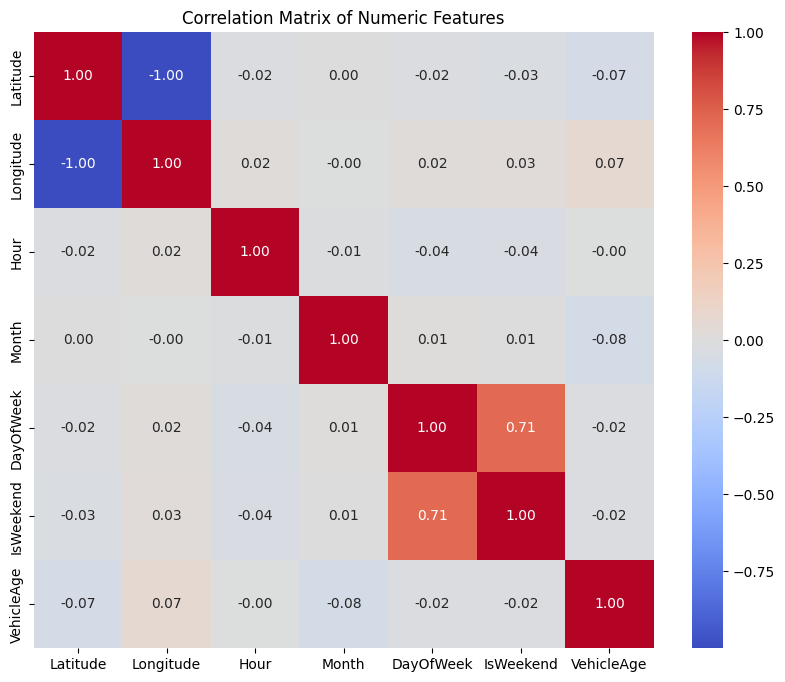

Highly correlated feature pairs (abs(corr) > 0.8):
Latitude - Longitude: -1.00


In [34]:
# ============================================================================
# 5.1.4. Integrate Data
# ============================================================================
# Requirement: Combine all the engineered and selected features into a final dataset suitable for modeling.
# Goal: Produce a unified, clean, and rich dataset with all features ready for clustering and outlier detection.
# Outcome: A finalized DataFrame with integrated numeric and categorical features.

print_step_header("5.1.4", "Integrate Data - Define feature categories and check redundancy")

# Define feature categories
feature_groups = {
    'Geographic': ['Latitude', 'Longitude'],
    'Temporal': ['Hour', 'Month', 'DayOfWeek', 'IsWeekend'],
    'Severity': ['Accident', 'Personal Injury', 'Property Damage', 'Fatal'],
    'Risk': ['Alcohol', 'Work Zone'],
    'Vehicle': ['VehicleAge', 'VehicleType', 'Commercial Vehicle', 'HAZMAT'],
    'Safety': ['Belts', 'Contributed To Accident'],
    'Demographic': ['Gender', 'Race'],
    'Enforcement': ['SubAgency']
}

# Consolidate all numeric features for redundancy check (example: numeric + encoded categorical)
numeric_features = ['Latitude', 'Longitude', 'Hour', 'Month', 'DayOfWeek', 'IsWeekend', 'VehicleAge']

# Calculate correlation matrix for numeric features
corr_matrix = dfoutlier[numeric_features].corr()

# Display correlation matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# Identify pairs with high correlation (threshold > 0.8)
high_corr_pairs = [(f1, f2, corr_matrix.loc[f1, f2])
                   for f1 in numeric_features for f2 in numeric_features
                   if f1 != f2 and abs(corr_matrix.loc[f1, f2]) > 0.8]

print("Highly correlated feature pairs (abs(corr) > 0.8):")
for f1, f2, corr_val in set(tuple(sorted([f1, f2])) + (corr_val,) for f1, f2, corr_val in high_corr_pairs):
    print(f"{f1} - {f2}: {corr_val:.2f}")

In [37]:
# ============================================================================
# 5.1.5. Format Data
# ============================================================================
# Requirement: Ensure all features have the correct data types for modeling. Format categorical features as numeric encoded types. Format numeric features as floats or integers with consistent precision.
# Goal: A well-structured dataset with consistent and appropriate formats.
# Outcome: Final cleaned and transformed dataset with properly formatted columns.

print_step_header("5.1.5", "Format Data with One-Hot Encoding and Normalization")

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Define categorical and numerical features
categorical_features = ['VehicleType', 'SubAgency', 'Gender', 'Race', 'TimeOfDay', 'VehicleAge_Binned', 'Hour_Binned']
numerical_features = ['Latitude', 'Longitude', 'Hour', 'Month', 'DayOfWeek', 'IsWeekend', 'VehicleAge']

# Separate categorical and numerical data
cat_data = dfoutlier[categorical_features]
num_data = dfoutlier[numerical_features]

# One-hot encode categorical variables
ohe = OneHotEncoder(sparse_output=False, drop='first')  # drop first to avoid multicollinearity
cat_encoded = ohe.fit_transform(cat_data)

# Normalize numerical variables to [0,1]
scaler = MinMaxScaler()
num_scaled = scaler.fit_transform(num_data)

# Combine back into one DataFrame
import numpy as np
import pandas as pd

encoded_feature_names = ohe.get_feature_names_out(categorical_features)
df_encoded_cat = pd.DataFrame(cat_encoded, columns=encoded_feature_names, index=dfoutlier.index)
df_scaled_num = pd.DataFrame(num_scaled, columns=numerical_features, index=dfoutlier.index)

df_final = pd.concat([df_scaled_num, df_encoded_cat], axis=1)

print("Final formatted dataset shape:", df_final.shape)
print(df_final.head())


# STEP 5.1.5: Format Data with One-Hot Encoding and Normalization
Final formatted dataset shape: (239234, 57)
    Latitude  Longitude      Hour     Month  DayOfWeek  IsWeekend  VehicleAge  \
1   0.976142   0.184042  0.739130  0.818182   0.333333        0.0         0.3   
2   0.972331   0.185115  0.739130  0.818182   0.333333        0.0         0.8   
10  0.974273   0.184676  0.739130  0.818182   0.333333        0.0         0.2   
14  0.974901   0.186118  0.695652  0.818182   0.333333        0.0         0.9   
19  0.971730   0.185298  0.695652  0.818182   0.333333        0.0         1.0   

    VehicleType_02 - Automobile  VehicleType_03 - Station Wagon  \
1                           1.0                             0.0   
2                           1.0                             0.0   
10                          1.0                             0.0   
14                          1.0                             0.0   
19                          1.0                             0.0   


In [18]:
# ============================================================================
# 6.1. Data Preparation
# ============================================================================

# ============================================================================
# 6.1.1. Select Data
# ============================================================================
# Requirement: At least 10 relevant attributes for anomaly detection
# Goal: Identify abnormal traffic patterns (fraud, data issues, systemic problems)
# Outcome: Multi-dimensional feature set covering spatial, temporal, severity, risk factors, and other key perspectives

print_step_header("6.1.1", "Select Data - Select and justify features for outlier detection")

# ============================================================================
# Step 1: Select and justify features for outlier detection
# ============================================================================

print_step_header("Step 1", "Select and justify features for outlier detection")

# Create data copy
df_outlier = df.copy()  # type: ignore  # noqa: F821

# Define feature groups (10+ modeling attributes required)
feature_groups = {
    'Geographic': ['Latitude', 'Longitude'],
    'Temporal': ['Date Of Stop', 'Time Of Stop'],
    'Severity': ['Accident', 'Personal Injury', 'Property Damage', 'Fatal'],  # KEY
    'Risk': ['Alcohol', 'Work Zone'],
    'Vehicle': ['Year', 'VehicleType', 'Commercial Vehicle', 'HAZMAT'],
    'Safety': ['Belts', 'Contributed To Accident'],
    'Demographics': ['Gender', 'Race'],
    'Enforcement': ['SubAgency'],
    'Auxiliary': ['SeqID', 'Location', 'Violation Type']  # Non-modeling
}

# Extract feature lists
geographic_features = feature_groups['Geographic']
temporal_features = feature_groups['Temporal']
severity_features = feature_groups['Severity']
risk_features = feature_groups['Risk']
vehicle_features = feature_groups['Vehicle']
safety_features = feature_groups['Safety']
demographic_features = feature_groups['Demographics']
enforcement_features = feature_groups['Enforcement']
auxiliary_features = feature_groups['Auxiliary']

# Consolidate all features
selected_features = (
    auxiliary_features + geographic_features + temporal_features +
    severity_features + risk_features + vehicle_features +
    safety_features + demographic_features + enforcement_features
)

# Filter dataset to selected features
df_outlier = df_outlier[selected_features].copy()

# Display results
modeling_features_count = len(selected_features) - len(auxiliary_features)
print("\n【Dataset Overview】")
print(f"- Total: {len(selected_features)} features ({modeling_features_count} modeling + {len(auxiliary_features)} auxiliary)")
print(f"- Shape: {df_outlier.shape[0]:,} rows × {df_outlier.shape[1]} columns")


# STEP 6.1.1: Select Data - Select and justify features for outlier detection

# STEP Step 1: Select and justify features for outlier detection

【Dataset Overview】
- Total: 22 features (19 modeling + 3 auxiliary)
- Shape: 2,057,154 rows × 22 columns


In [ ]:
# ============================================================================
# 6.1.2. Clean Data
# ============================================================================
# Requirement: Remove duplicates, handle missing values, validate data quality
# Goal: Ensure data integrity and reliability for accurate anomaly detection
# Outcome: Clean, validated dataset ready for feature engineering

print_step_header("6.1.2", "Clean Data")

# ============================================================================
# Step 1: Remove duplicate rows
# ============================================================================

print_step_header("Step 1", "Remove duplicate rows")

# Record initial state
rows_before = df_outlier.shape[0]

# Remove duplicates (keep first occurrence)
df_outlier.drop_duplicates(subset=['SeqID'], keep='first', inplace=True)

# Display results
rows_after = df_outlier.shape[0]
duplicates_removed = rows_before - rows_after
print("\n【Deduplication Results】")
print(f"- Records before: {rows_before:,}")
print(f"- Records after: {rows_after:,}")
print(f"- Duplicates removed: {duplicates_removed:,} ({duplicates_removed/rows_before*100:.2f}%)")
print("- Strategy: Keep first occurrence based on SeqID")


# STEP 6.1.2: Clean Data

# STEP Step 1: Remove duplicate rows

【Deduplication Results】
- Records before: 2,057,983
- Records after: 1,170,571
- Duplicates removed: 887,412 (43.12%)
- Strategy: Keep first occurrence based on SeqID


In [ ]:
# ============================================================================
# Step 2: Check missing values
# ============================================================================

print_step_header("Step 2", "Check missing values")

# Check missing values
missing_stats = df_outlier.isnull().sum()
missing_stats_pct = (missing_stats / len(df_outlier) * 100).round(2)

# Display results
print("\n【Missing Values Overview】")
print(pd.DataFrame({
    'Missing Count': missing_stats[missing_stats > 0],
    'Percentage': missing_stats_pct[missing_stats > 0]
}))
print("\nNote: Missing values will be handled after feature engineering")


# STEP Step 2: Check missing values

【Missing Values Overview】
          Missing Count  Percentage
Location              2        0.00
Year               9858        0.84

Note: Missing values will be handled after feature engineering


In [ ]:
# ============================================================================
# Step 3: Data validation and remove invalid records
# ============================================================================

print_step_header("Step 3", "Data validation and remove invalid records")

# 1. Geographic coordinate validation
invalid_lat = ((df_outlier['Latitude'] < -90) | (df_outlier['Latitude'] > 90)).sum()
invalid_lon = ((df_outlier['Longitude'] < -180) | (df_outlier['Longitude'] > 180)).sum()

# 2. Temporal validation
invalid_year = ((df_outlier['Year'] < 1900) | (df_outlier['Year'] > 2025)).sum()

# Date validation (parse and check range: 2015-2025)
df_outlier['Date Of Stop'] = pd.to_datetime(df_outlier['Date Of Stop'], errors='coerce')
invalid_date = df_outlier['Date Of Stop'].isnull().sum()
invalid_date_range = ((df_outlier['Date Of Stop'] < '2015-01-01') | (df_outlier['Date Of Stop'] > '2025-12-31')).sum()

# Time validation
df_outlier['Time Of Stop'] = pd.to_datetime(df_outlier['Time Of Stop'], format='%H:%M:%S', errors='coerce').dt.time
invalid_time = df_outlier['Time Of Stop'].isnull().sum()

# 3. Binary fields validation (should be bool: True/False)
binary_fields = [
    'Accident', 'Personal Injury', 'Property Damage', 'Fatal',
    'Alcohol', 'Work Zone', 'Belts', 'Contributed To Accident',
    'Commercial Vehicle', 'HAZMAT'
]
# Count invalid binary values (should only be True/False)
invalid_binary = sum((~df_outlier[field].isin([True, False])).sum() for field in binary_fields)

# Remove invalid records
rows_before_validation = df_outlier.shape[0]
valid_mask = (
    (df_outlier['Latitude'] >= -90) & (df_outlier['Latitude'] <= 90) &
    (df_outlier['Longitude'] >= -180) & (df_outlier['Longitude'] <= 180) &
    (df_outlier['Year'] >= 1900) & (df_outlier['Year'] <= 2025) &
    (df_outlier['Date Of Stop'].notnull()) &
    (df_outlier['Date Of Stop'] >= '2015-01-01') & (df_outlier['Date Of Stop'] <= '2025-12-31') &
    (df_outlier['Time Of Stop'].notnull())
)
# Check each binary field for valid boolean values
for field in binary_fields:
    valid_mask &= df_outlier[field].isin([True, False])

df_outlier = df_outlier[valid_mask]

# Display results
rows_removed = rows_before_validation - df_outlier.shape[0]
print("\n【Data Quality Checks】")
print("1. Geographic Coordinates:")
print(f"   - Invalid Latitude values: {invalid_lat}")
print(f"   - Invalid Longitude values: {invalid_lon}")
print("2. Temporal:")
print(f"   - Invalid Year values: {invalid_year}")
print(f"   - Invalid Date Of Stop (null): {invalid_date}")
print(f"   - Invalid Date Of Stop (out of range 2015-2025): {invalid_date_range}")
print(f"   - Invalid Time Of Stop (null): {invalid_time}")
print("3. Binary Fields (True/False):")
print(f"   - Invalid boolean values: {invalid_binary}")

print("\n【Data Validation Results】")
print(f"- Removed {rows_removed:,} records with invalid data")
print(f"- Remaining records: {df_outlier.shape[0]:,}")


# STEP Step 3: Data validation and remove invalid records

【Data Quality Checks】
1. Geographic Coordinates:
   - Invalid Latitude values: 0
   - Invalid Longitude values: 0
2. Temporal:
   - Invalid Year values: 1428
   - Invalid Date Of Stop (null): 0
   - Invalid Date Of Stop (out of range 2015-2025): 334113
   - Invalid Time Of Stop (null): 0
3. Binary Fields (True/False):
   - Invalid boolean values: 0

【Data Validation Results】
- Removed 342,116 records with invalid data
- Remaining records: 828,455


In [ ]:
# ============================================================================
# Step 4: Apply sampling technique (stratified sampling)
# ============================================================================

print_step_header("Step 4", "Apply sampling technique (stratified sampling)")

# Calculate sample size (as per project requirements: 10,000 records)
original_size = len(df_outlier)
target_sample_size = 10000
sample_fraction = target_sample_size / original_size

# Stratified sampling by 'Accident' (key severity indicator)
# This ensures the proportion of each class is maintained in the sample
df_outlier = df_outlier.groupby('Accident', group_keys=False).apply(
    lambda x: x.sample(frac=sample_fraction, random_state=42)
)

# Display results
print("\n【Sampling Results】")
print(f"- Original size: {original_size:,} records")
print(f"- Sample size: {len(df_outlier):,} records ({len(df_outlier)/original_size*100:.1f}%)")
print("- Sampling method: Stratified sampling by 'Accident'")
print(f"- Sampling fraction: {sample_fraction:.4f}")
print("- Accident distribution maintained:")
print(df_outlier['Accident'].value_counts(normalize=True).round(4))


# STEP Step 4: Apply sampling technique (stratified sampling)

【Sampling Results】
- Original size: 10,000 records
- Sample size: 10,000 records (100.0%)
- Sampling method: Stratified sampling by 'Accident'
- Sampling fraction: 1.0000
- Accident distribution maintained:
Accident
0    0.9812
1    0.0188
Name: proportion, dtype: float64


C:\Users\40270\AppData\Local\Temp\ipykernel_1728\3237969908.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_outlier = df_outlier.groupby('Accident', group_keys=False).apply(


In [ ]:
# ============================================================================
# 6.1.3. Construct Data
# ============================================================================
# Requirement: Feature engineering - create new meaningful attributes
# Goal: Extract temporal patterns and vehicle characteristics to enhance anomaly detection capability
# Outcome: Enriched feature set with temporal components, vehicle age, and optional binning features

print_step_header("6.1.3", "Construct Data - Feature Engineering")

# ============================================================================
# Step 1: Create temporal features
# ============================================================================

print_step_header("Step 1", "Create temporal features")

# Combine date and time (Date Of Stop is already datetime, Time Of Stop is time object)
# Convert Time Of Stop back to string for combination
df_outlier['Time_str'] = df_outlier['Time Of Stop'].astype(str)
df_outlier['DateTime'] = pd.to_datetime(
    df_outlier['Date Of Stop'].astype(str) + ' ' + df_outlier['Time_str'],
    errors='coerce'
)
df_outlier.drop('Time_str', axis=1, inplace=True)

# Extract temporal components
df_outlier['Hour'] = df_outlier['DateTime'].dt.hour
df_outlier['Month'] = df_outlier['DateTime'].dt.month
df_outlier['DayOfWeek'] = df_outlier['DateTime'].dt.dayofweek  # 0=Monday, 6=Sunday
df_outlier['IsWeekend'] = (df_outlier['DayOfWeek'] >= 5).astype(int)

# Create time of day categories
def categorize_time_of_day(hour):
    if pd.isna(hour):
        return 'Unknown'
    elif 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

df_outlier['TimeOfDay'] = df_outlier['Hour'].apply(categorize_time_of_day)

# Display results
print("\n【Temporal Features Created】")
print("- Hour: 0-23")
print("- Month: 1-12")
print("- DayOfWeek: 0-6 (0=Monday)")
print("- IsWeekend: 0/1")
print("- TimeOfDay: Night/Morning/Afternoon/Evening")


# STEP 6.1.3: Construct Data - Feature Engineering

# STEP Step 1: Create temporal features

【Temporal Features Created】
- Hour: 0-23
- Month: 1-12
- DayOfWeek: 0-6 (0=Monday)
- IsWeekend: 0/1
- TimeOfDay: Night/Morning/Afternoon/Evening


In [ ]:
# ============================================================================
# Step 2: Create vehicle age feature
# ============================================================================

print_step_header("Step 2", "Create vehicle age feature")

# Calculate vehicle age
current_year = 2025
df_outlier['VehicleAge'] = current_year - df_outlier['Year']

# Handle outliers: cap at reasonable maximum (50 years for very old vehicles)
df_outlier['VehicleAge'] = df_outlier['VehicleAge'].clip(lower=0, upper=50)

# Display results
print("\n【Vehicle Age Statistics】")
print(f"- Formula: VehicleAge = {current_year} - Year")
print(f"- Mean age: {df_outlier['VehicleAge'].mean():.1f} years")
print(f"- Median age: {df_outlier['VehicleAge'].median():.1f} years")
print(f"- Range: {df_outlier['VehicleAge'].min():.0f} - {df_outlier['VehicleAge'].max():.0f} years")
print("- Outliers capped at 50 years")


# STEP Step 2: Create vehicle age feature

【Vehicle Age Statistics】
- Formula: VehicleAge = 2025 - Year
- Mean age: 14.9 years
- Median age: 14.0 years
- Range: 0 - 50 years
- Outliers capped at 50 years


In [ ]:
# ============================================================================
# Step 3: Create binning features (optional)
# ============================================================================

print_step_header("Step 3", "Create binning features (optional)")

# VehicleAge binning using if conditions
def bin_vehicle_age(age):
    if age <= 3:
        return 'New'
    elif age <= 7:
        return 'Recent'
    elif age <= 15:
        return 'Middle'
    else:
        return 'Old'

df_outlier['VehicleAge_Binned'] = df_outlier['VehicleAge'].apply(bin_vehicle_age)

# Hour binning using if conditions
def bin_hour(hour):
    if hour <= 6:
        return 'Night'
    elif hour <= 12:
        return 'Morning'
    elif hour <= 18:
        return 'Afternoon'
    else:
        return 'Evening'

df_outlier['Hour_Binned'] = df_outlier['Hour'].apply(bin_hour)

# Display results
print("\n【Binning Features Created】")
print(f"- VehicleAge_Binned: {df_outlier['VehicleAge_Binned'].value_counts().to_dict()}")
print(f"- Hour_Binned: {df_outlier['Hour_Binned'].value_counts().to_dict()}")
print("\nNote: Binning is optional. These features can be used or excluded based on model performance.")


# STEP Step 3: Create binning features (optional)

【Binning Features Created】
- VehicleAge_Binned: {'Middle': 4459, 'Old': 4372, 'Recent': 887, 'New': 282}
- Hour_Binned: {'Morning': 3035, 'Evening': 2669, 'Afternoon': 2662, 'Night': 1634}

Note: Binning is optional. These features can be used or excluded based on model performance.


In [ ]:
# ============================================================================
# Step 4: Handle missing values after feature engineering
# ============================================================================

print_step_header("Step 4", "Handle missing values after feature engineering")

# Check missing values after feature engineering
rows_before = df_outlier.shape[0]
missing_stats = df_outlier.isnull().sum()
missing_stats_pct = (missing_stats / len(df_outlier) * 100).round(2)

# Display results
print("\n【Missing Values After Feature Engineering】")
print(pd.DataFrame({
    'Missing Count': missing_stats[missing_stats > 0],
    'Percentage': missing_stats_pct[missing_stats > 0]
}))

# Strategy: Remove rows with missing values
# Reason: Missing values are minimal (<1%), deletion preserves data quality
df_outlier.dropna(inplace=True)

# Display results
rows_after = df_outlier.shape[0]
print("\n【Missing Value Handling Results】")
print(f"- Records before: {rows_before:,}")
print(f"- Records after: {rows_after:,}")
print(f"- Records removed: {rows_before - rows_after:,} ({(rows_before - rows_after)/rows_before*100:.2f}%)")
print("- Strategy: Delete rows with any missing values")
print("- Reason: Missing values minimal, complete data is more reliable for outlier detection")



# STEP Step 4: Handle missing values after feature engineering

【Missing Values After Feature Engineering】
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []

【Missing Value Handling Results】
- Records before: 10,000
- Records after: 10,000
- Records removed: 0 (0.00%)
- Strategy: Delete rows with any missing values
- Reason: Missing values minimal, complete data is more reliable for outlier detection


In [ ]:
# ============================================================================
# 6.1.4. Integrate Data
# ============================================================================
# Requirement: Organize features by type, check for redundancy and multicollinearity
# Goal: Ensure feature independence and avoid redundant information
# Outcome: Well-organized feature set with minimal redundancy, ready for modeling

print_step_header("6.1.4", "Integrate Data - Define feature categories and check redundancy")

# ============================================================================
# Step 1: Define feature categories and check redundancy
# ============================================================================

print_step_header("Step 1", "Define feature categories and check redundancy")

# Define modeling feature categories
numerical_features = ['Latitude', 'Longitude', 'Hour', 'Month', 'DayOfWeek', 'IsWeekend', 'VehicleAge']

boolean_features = [
    'Accident', 'Personal Injury', 'Property Damage', 'Fatal',
    'Alcohol', 'Work Zone', 'Commercial Vehicle', 'HAZMAT',
    'Belts', 'Contributed To Accident'
]

categorical_features = ['VehicleType', 'SubAgency', 'Gender', 'Race', 'TimeOfDay']

# Optional binned features (not included in main modeling)
optional_binned_features = ['VehicleAge_Binned', 'Hour_Binned']

# Check redundancy
# Original time columns (Date Of Stop, Time Of Stop) will NOT be used for modeling
# Only use engineered temporal features

# Display results
total_features = len(numerical_features) + len(boolean_features) + len(categorical_features)
print("\n【Final Modeling Features】")
print(f"- Total: {total_features} features (≥ 10 ✓)")
print("\n【Feature Categories】")
print(f"- Numerical: {len(numerical_features)} features")
print(f"  {numerical_features}")
print(f"- Boolean: {len(boolean_features)} features")
print(f"  {boolean_features}")
print(f"- Categorical: {len(categorical_features)} features")
print(f"  {categorical_features}")
print("\n【Feature Purpose by Dimension】")
print("- Spatial: Latitude, Longitude")
print("- Temporal: Hour, Month, DayOfWeek, IsWeekend, TimeOfDay")
print("- Severity: Accident, Personal Injury, Property Damage, Fatal")
print("- Risk: Alcohol, Work Zone")
print("- Vehicle: VehicleAge, VehicleType, Commercial Vehicle, HAZMAT")
print("- Enforcement: SubAgency")
print("- Demographics: Gender, Race")
print("- Safety: Belts, Contributed To Accident")


# STEP 6.1.4: Integrate Data - Define feature categories and check redundancy

# STEP Step 1: Define feature categories and check redundancy

【Final Modeling Features】
- Total: 22 features (≥ 10 ✓)

【Feature Categories】
- Numerical: 7 features
  ['Latitude', 'Longitude', 'Hour', 'Month', 'DayOfWeek', 'IsWeekend', 'VehicleAge']
- Boolean: 10 features
  ['Accident', 'Personal Injury', 'Property Damage', 'Fatal', 'Alcohol', 'Work Zone', 'Commercial Vehicle', 'HAZMAT', 'Belts', 'Contributed To Accident']
- Categorical: 5 features
  ['VehicleType', 'SubAgency', 'Gender', 'Race', 'TimeOfDay']

【Feature Purpose by Dimension】
- Spatial: Latitude, Longitude
- Temporal: Hour, Month, DayOfWeek, IsWeekend, TimeOfDay
- Severity: Accident, Personal Injury, Property Damage, Fatal
- Risk: Alcohol, Work Zone
- Vehicle: VehicleAge, VehicleType, Commercial Vehicle, HAZMAT
- Enforcement: SubAgency
- Demographics: Gender, Race
- Safety: Belts, Contributed To Accident



# STEP Step 2: Correlation analysis


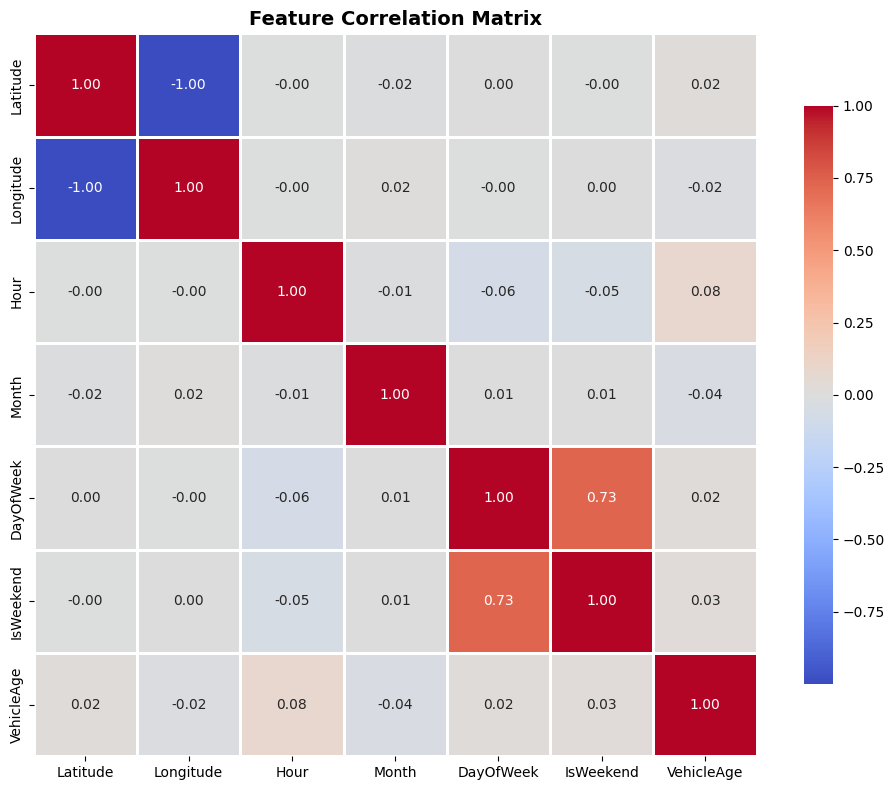


【Correlation Analysis】
- Numerical features analyzed: 7
- Highly correlated pairs (|r| > 0.8): 1

【High Correlation Pairs】
  Latitude ↔ Longitude: -1.000
Note: Review and potentially remove one feature from each highly correlated pair


In [ ]:
# ============================================================================
# Step 2: Correlation analysis
# ============================================================================

print_step_header("Step 2", "Correlation analysis")

# Calculate correlation matrix for numerical features
correlation_matrix = df_outlier[numerical_features].corr()

# Identify highly correlated pairs (|correlation| > 0.8)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.8:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                corr_value
            ))

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Display results
print("\n【Correlation Analysis】")
print(f"- Numerical features analyzed: {len(numerical_features)}")
print(f"- Highly correlated pairs (|r| > 0.8): {len(high_corr_pairs)}")

print("\n【High Correlation Pairs】")
for feat1, feat2, corr in high_corr_pairs:
    print(f"  {feat1} ↔ {feat2}: {corr:.3f}")
print("Note: Review and potentially remove one feature from each highly correlated pair")

In [ ]:
# ============================================================================
# 6.1.5. Format Data
# ============================================================================
# Requirement: Encode categorical variables, scale numerical features, validate data quality
# Goal: Transform data into algorithm-ready format for distance-based anomaly detection
# Outcome: Fully prepared, scaled feature matrix ready for outlier detection algorithms

print_step_header("6.1.5", "Format Data - Encode, scale, and validate")

# ============================================================================
# Step 1: Encode categorical variables
# ============================================================================

print_step_header("Step 1", "Encode categorical variables")

# Initialize encoders dictionary
encoders = {}

# Encode categorical features
for feature in categorical_features:
    # Apply LabelEncoder
    le = LabelEncoder()
    df_outlier[f'{feature}_encoded'] = le.fit_transform(df_outlier[feature])

    # Save encoder for later interpretation
    encoders[feature] = le

# Display results
print("\n【Encoding Results】")
for feature in categorical_features:
    le = encoders[feature]
    print(f"- {feature}: {len(le.classes_)} unique values → encoded")


# STEP 6.1.5: Format Data - Encode, scale, and validate

# STEP Step 1: Encode categorical variables

【Encoding Results】
- VehicleType: 20 unique values → encoded
- SubAgency: 7 unique values → encoded
- Gender: 3 unique values → encoded
- Race: 6 unique values → encoded
- TimeOfDay: 4 unique values → encoded


In [ ]:
# ============================================================================
# Step 2: Create feature matrix and validate data types
# ============================================================================

print_step_header("Step 2", "Create feature matrix and validate data types")

# Create feature matrix: integrate numerical, boolean, encoded features
encoded_categorical_features = [f'{f}_encoded' for f in categorical_features]
all_modeling_features = numerical_features + boolean_features + encoded_categorical_features

# Convert boolean features to integers (0/1)
for feature in boolean_features:
    df_outlier[feature] = df_outlier[feature].astype(int)

# Create feature matrix
X_outlier = df_outlier[all_modeling_features].copy()

# Display results
print("\n【Feature Matrix】")
print(f"- Shape: {X_outlier.shape[0]:,} rows × {X_outlier.shape[1]} columns")
print(f"- Data types: {X_outlier.dtypes.value_counts().to_dict()}")
print(f"- Missing values: {X_outlier.isnull().sum().sum()}")


# STEP Step 2: Create feature matrix and validate data types

【Feature Matrix】
- Shape: 10,000 rows × 22 columns
- Data types: {dtype('int64'): 16, dtype('int32'): 3, dtype('float64'): 2, Int64Dtype(): 1}
- Missing values: 0


In [ ]:
# ============================================================================
# Step 3: Feature scaling
# ============================================================================

print_step_header("Step 3", "Feature scaling")

# Initialize scaler
scaler = StandardScaler()

# Fit and transform features
X_outlier_scaled = scaler.fit_transform(X_outlier)

# Convert back to DataFrame for readability
X_outlier_scaled = pd.DataFrame(
    X_outlier_scaled,
    columns=X_outlier.columns,
    index=X_outlier.index
)

# Display results
print("\n【Scaling Results】")
print("- Method: StandardScaler (mean=0, std=1)")
print(f"- Scaled matrix shape: {X_outlier_scaled.shape}")
print(f"- Mean after scaling: {X_outlier_scaled.mean().mean():.6f}")
print(f"- Std after scaling: {X_outlier_scaled.std().mean():.6f}")


# STEP Step 3: Feature scaling

【Scaling Results】
- Method: StandardScaler (mean=0, std=1)
- Scaled matrix shape: (10000, 22)
- Mean after scaling: 0.000000
- Std after scaling: 0.909136


In [ ]:
# ============================================================================
# Step 4: Final validation
# ============================================================================

print_step_header("Step 4", "Final validation")

# Check for NaN values
nan_count = X_outlier_scaled.isnull().sum().sum()

# Check for Inf values
inf_count = np.isinf(X_outlier_scaled).sum().sum()

# Display results
print("\n【Data Quality Checks】")
print(f"- NaN values: {nan_count}")
print(f"- Inf values: {inf_count}")

# Confirm shape and data types
print("\n【Final Feature Matrix】")
print(f"- Shape: {X_outlier_scaled.shape[0]:,} rows × {X_outlier_scaled.shape[1]} columns")
print(f"- Data types: {X_outlier_scaled.dtypes.value_counts().to_dict()}")
print(f"- Memory usage: {X_outlier_scaled.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Data quality confirmation
print("\n【Validation Results】")
print(f"Final dataset: {X_outlier_scaled.shape[0]:,} records × {X_outlier_scaled.shape[1]} features")




# STEP Step 4: Final validation

【Data Quality Checks】
- NaN values: 0
- Inf values: 0

【Final Feature Matrix】
- Shape: 10,000 rows × 22 columns
- Data types: {dtype('float64'): 22}
- Memory usage: 1.75 MB

【Validation Results】
Final dataset: 10,000 records × 22 features
